In [4]:
import networkx as nx

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.sparse import *

In [6]:
from lib import models,graph,coarsening, utils

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#data

In [12]:
d1 = load_npz('../data/interim/adj_sparse/MItoMI-2013-11-01.npz')

In [13]:
#number of grids in the graph
d = 100
n = 10000

In [14]:
#graph between grids
d1_dense = d1.todense()

In [36]:
#find the laplacian graph of the adjacency matrice
L = graph.laplacian(d1, normalized = True)

In [ ]:
graph.plot_spectrum([L])

In [ ]:
#apply gcn to signals lying on graphs
params = dict()
params['dir_name'] = 'test_day1'
params['num_epochs'] = 10
params['batch_size'] = 100
params['eval_frequency'] = 100

#building block
params['filter'] = 'chebyshev5'
params['brelu'] = 'b1relu'
params['pool'] = 'apool1'

#number of classes
C = 5

#architecture
params['F'] = [32,64]
params['K'] = [20,20]
params['p'] = [4,2]
params['M'] = [512, C]

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [29]:
m**2

matrix([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 7.6993280e-03, 7.8512561e-03, ..., 1.2474899e-04,
         1.8410217e-04, 2.2727025e-04],
        [0.0000000e+00, 7.8728208e-03, 8.0285259e-03, ..., 1.2812825e-04,
         1.8752726e-04, 2.3018903e-04],
        ...,
        [0.0000000e+00, 9.1189249e-05, 8.3669947e-05, ..., 1.1059108e-01,
         9.0724386e-02, 7.5114444e-02],
        [0.0000000e+00, 7.9822283e-05, 8.1680177e-05, ..., 7.9181209e-02,
         6.6082776e-02, 5.6290068e-02],
        [0.0000000e+00, 8.2835417e-05, 8.4908927e-05, ..., 7.3125467e-02,
         6.1586861e-02, 5.3350411e-02]], dtype=float32)

In [32]:
z = graph.grid(100)

In [33]:
z

array([[0.        , 0.        ],
       [0.01010101, 0.        ],
       [0.02020202, 0.        ],
       ...,
       [0.97979796, 1.        ],
       [0.989899  , 1.        ],
       [1.        , 1.        ]], dtype=float32)

Class imblance: [3470 2962 3568]


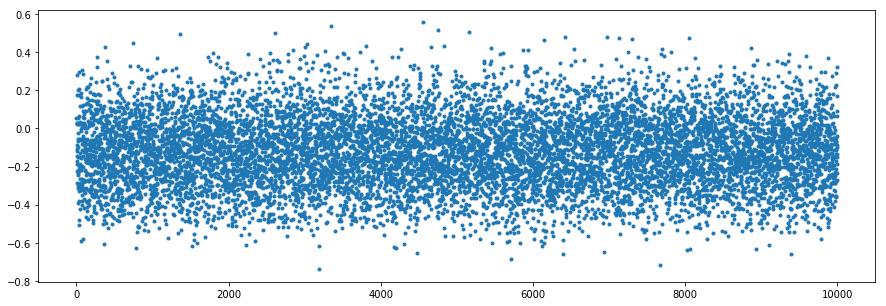

In [72]:
d = 100
n = 10000
c = 5

#data matrix structured in communities (feature wise)
X = np.random.normal(0,1,(n,d)).astype(np.float32)
X += np.linspace(0,1,c).repeat(d//c)

#noisy non-linear target
w = np.random.normal(0,.02,d)
t = X.dot(w) + np.random.normal(0, .001, n)
t = np.tanh(t)
plt.figure(figsize = (15,5))
plt.plot(t,'.')

#classification
y = np.ones(t.shape, dtype = np.uint8)
y[t > t.mean() + 0.4 * t.std()] = 0
y[t < t.mean() - 0.4 * t.std()] = 2
print('Class imblance:', np.unique(y,return_counts = True)[1])

In [73]:
# split the dataset into training validation and testing sets
n_train = n//2
n_val = n//10
X_train = X[:n_train]
X_val = X[n_train:n_train+n_val]
X_test = X[n_train+n_val:]

y_train = y[:n_train]
y_val = y[n_train:n_train+n_val]
y_test = y[n_train+n_val:]

build a graph measuring the similarity between features
use euclidean distance function
use gaussian kernel
use knn graph

d = |V| = 100,k|V| < |E| = 1348


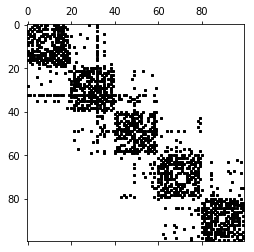

In [74]:
#return the k nearest vertex
dist, idx = graph.distance_scipy_spatial(X_train.T, k = 10, metric ='euclidean')
d = 100
A = graph.adjacency(dist, idx).astype(np.float32)

assert A.shape == (d,d)
print('d = |V| = {},k|V| < |E| = {}'.format(d,A.nnz))
plt.spy(A,markersize = 2, color = 'black')

In [45]:
graps,perm = coarsening.coarsen(A,levels = 3, self_connections = False)

X_train = coarsening.perm_data(X_train, perm)
X_val = coarsening.perm_data(X_val, perm)
X_test = coarsening.perm_data(X_test, perm)

Layer 0: M_0 = |V| = 112 nodes (12 added),|E| = 657 edges
Layer 1: M_1 = |V| = 56 nodes (4 added),|E| = 353 edges
Layer 2: M_2 = |V| = 28 nodes (1 added),|E| = 134 edges
Layer 3: M_3 = |V| = 14 nodes (0 added),|E| = 47 edges


In [46]:
from lib import graph

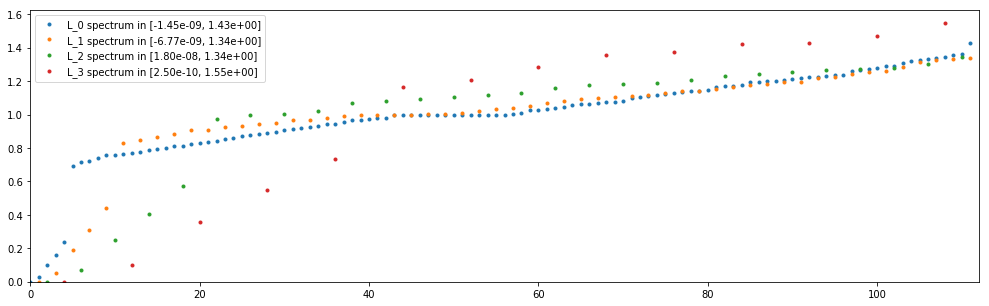

In [47]:
L = [graph.laplacian(A,normalized = True) for A in graps]
graph.plot_spectrum(L)

可以看到每一个维度上的特征值，表示了傅立叶基的频率，图越粗，得到的特征值就越少

In [77]:
L[3].shape

(14, 14)

以下对图上的信号进行图卷积

In [56]:
#graph convNet
params = dict()
params['dir_name'] = 'demo'
params['num_epochs'] = 40
params['batch_size'] = 100
params['eval_frequency'] = 200

# Building blocks
params['filter'] = 'chebyshev5'
params['brelu'] =  'b1relu'
params['pool'] = 'apool1'

#Number of classes
C = y.max() + 1
assert C == np.unique(y).size

#Architecture
params['F'] = [32,64] #Number of graph convolutional filters
params['K'] = [20,20] # polynomial orders
params['p'] = [4,2] # pooling sizes
params['M'] = [512,C]

#Optimization
params['regularization'] = 5e-4
params['dropout'] = 1
params['learning_rate'] = 1e-3
params['decay_rate'] = 0.95
params['momentum'] = 0.9
params['decay_steps'] = n_train/params['batch_size']

In [58]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train,X_val, y_val)

NN architecture
  input: M_0 = 112
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 112 * 32 / 4 = 896
    weights: F_0 * F_1 * K_1 = 1 * 32 * 20 = 640
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 28 * 64 / 2 = 896
    weights: F_1 * F_2 * K_2 = 32 * 64 * 20 = 40960
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 896 * 512 = 458752
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 3
    weights: M_3 * M_4 = 512 * 3 = 1536
    biases: M_4 = 3
step 200 / 2000 (epoch 4.00 / 40):
  learning_rate = 8.57e-04, loss_average = 1.87e+00
  validation accuracy: 52.90 (529 / 1000), f1 (weighted): 49.07, loss: 1.87e+00
  time: 78s (wall 24s)
step 400 / 2000 (epoch 8.00 / 40):
  learning_rate = 6.98e-04, loss_average = 1.78e+00
  validation accuracy: 56.90 (569 / 1000), f1 (weighted): 57.11, loss: 1.79e+00
  time: 154s (wall 48s)
step 600 / 2000 (epoch 12.00 / 40):
  learning_rate = 5.69e-04,

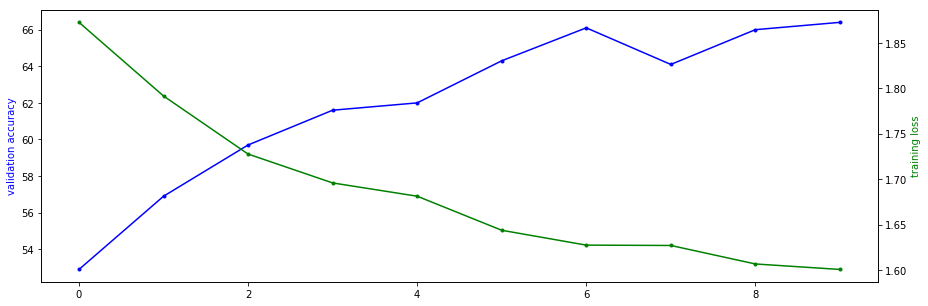

In [62]:
#evalutaion
# we often want to monitor the convergence. i.e. the training loss and the classification accuracy on the valdation set
# the performance i.e. the classificationaccuracy on the testing set (to be compared with the training set accuracy to spot overfitting)

fig,ax1 = plt.subplots(figsize = (15,5))
ax1.plot(accuracy,'b.-')
ax1.set_ylabel('validation accuracy', color = 'b')
ax2 = ax1.twinx()
ax2.plot(loss,'g.-')
ax2.set_ylabel('training loss', color = 'g')
plt.show()

In [64]:
print('Time per step:{:.2f} ms'.format(t_step*1000))

Time per step:115.77 ms


In [65]:
res = model.evaluate(X_test,y_test)
print(res[0])

INFO:tensorflow:Restoring parameters from D:\MobileTrafficPrediction\notebooks\lib\..\checkpoints\demo\model-2000
accuracy: 67.53 (2701 / 4000), f1 (weighted): 66.98, loss: 1.60e+00
time: 9s (wall 3s)
